In [1]:
# System Libraries
import os

# Mathematical Libraries
import numpy as np
from scipy.optimize import curve_fit

# Plotting Libraries
import matplotlib.pyplot as plt

# Data management Libraries
import pandas as pd
import pickle

In [2]:
cm = 1e-2
mm = 1e-3
um = 1e-6

mA = 1e-3
uA = 1e-6
nA = 1e-9

# Obtaining relevant values for calculation

## LED Board Power Measurements

In [80]:
# Loading the CSV file containing the measured LED current
file_loc_meas = os.path.join(os.getcwd(), 'data', 'Power Response','Measurements', '2023-11-14 Power Measurement.csv')
df_meas = pd.read_csv(file_loc_meas, header=0)
meas_vals = np.zeros((len(df_meas), 2))
meas_vals[:,0] = df_meas['Voltage (V)'].to_numpy()
meas_vals[:,1] = df_meas['PD Current'].to_numpy()

In [ ]:
df_meas

,Voltage (V),Current (mA),Calculated Current (mA),Approximated,PD Current
0,2.55,23.32,22.368421,22.36,0.96
1,2.65,24.08,23.245614,23.24,0.84
2,2.75,25.04,24.122807,24.12,0.92
3,2.85,25.90,25.000000,25.00,0.90
4,2.95,26.91,25.877193,25.87,1.04
5,3.05,27.74,26.754386,26.75,0.99
6,3.15,28.81,27.631579,27.63,1.18
7,3.25,29.87,28.508772,28.50,1.37
8,3.35,30.84,29.385965,29.38,1.46
9,3.45,31.88,30.263158,30.26,1.62


## LED Luminescence

### Loading the files

In [5]:
# Loading the CSV file containing the datasheet values of luminescence
file_loc_ds = os.path.join(os.getcwd(), 'data', 'Power Response','LED Datasheet', 'VLMTG1400 Absolute Luminescence.csv')
df_ds = pd.read_csv(file_loc_ds, header=0, index_col=0)

# Convert the df_ds to a numpy matrix
ds = np.zeros((len(df_ds), 2))
ds[:,1] = df_ds.to_numpy()[:,0]
ds[:,0] = df_ds.index.values

### FItting the curve to the datasheet data

In [6]:
# Fitting a polynomial to ds
def fit_polynomial(x_data, y_data, degree):
    # Fit the polynomial
    coeffs = np.polyfit(x_data, y_data, degree)
    # Generate a polynomial function from the coefficients
    p = np.poly1d(coeffs)
    return p

# Fit a second-degree polynomial to the data (in log-log space for better handling of wide value ranges)
degree_x = 2
polynomial_model = fit_polynomial(np.log10(ds[:, 0]), np.log10(ds[:, 1]), degree_x)

# Predict the luminescence using the polynomial model
log_current_data = np.log10(ds[:, 0]).reshape(-1, 1)
log_current_data_fine = np.linspace(min(log_current_data), max(log_current_data), 1000)
luminescence_polynomial_fitted = 10**polynomial_model(log_current_data_fine)

### Plotting the fit polynomial

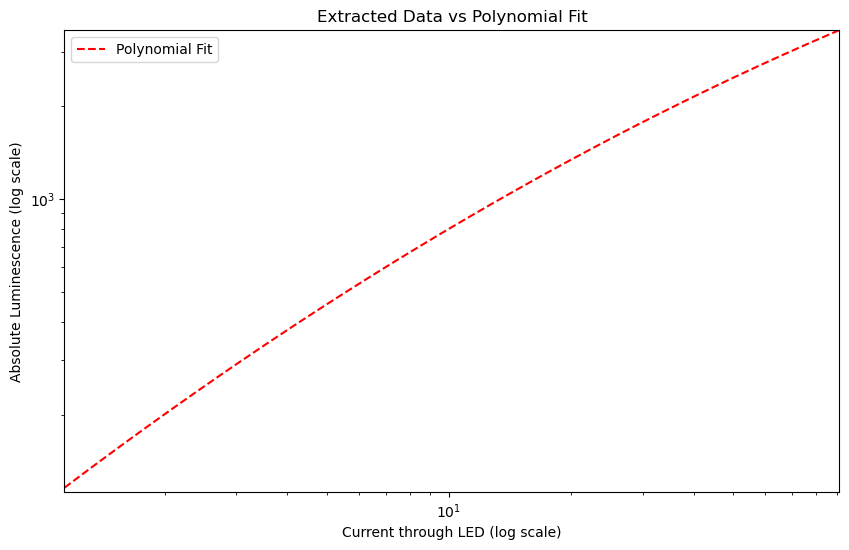

In [7]:
# Plot both the extracted data and the polynomial fitted model for comparison
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')
plt.plot(10**log_current_data_fine, luminescence_polynomial_fitted, c='red', linestyle='--', label='Polynomial Fit')
plt.xlim([min(ds[:, 0]), max(ds[:, 0])])
plt.ylim([min(ds[:, 1]), max(ds[:, 1])])
plt.xlabel('Current through LED (log scale)')
plt.ylabel('Absolute Luminescence (log scale)')
plt.title('Extracted Data vs Polynomial Fit')
plt.legend()
plt.show()

### Calculating the LED response to the functions
The LED response to different current levels is calculated and is then plotted as a function of voltage input to the source circuit. An exponential fit is performed to get a model for calculating teh luminence from the source LED for an arbitrary vaue of source voltage input

In [8]:
# Calculate the power response
new_col = 10**polynomial_model(meas_vals[:, 1])
meas_vals = np.append(meas_vals, new_col.reshape(-1, 1), axis=1)

C:\Users\nkottap\AppData\Local\Temp\ipykernel_26488\3503943052.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


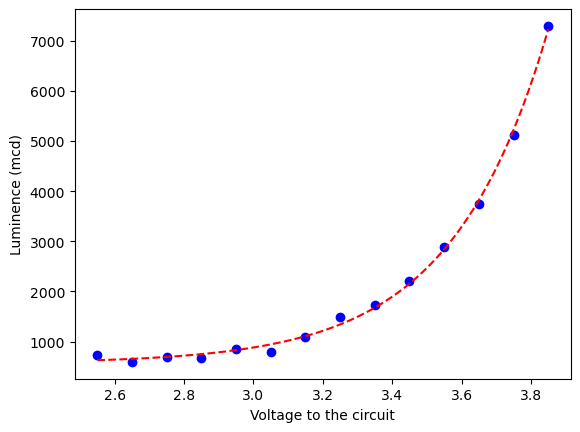

In [9]:
# Fit an exponential curve to the data
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(exponential_func, meas_vals[:, 0], meas_vals[:, 2])

# Generate a set of x values for the fitted curve
x_fit = np.linspace(min(meas_vals[:, 0]), max(meas_vals[:, 0]), 1000)

# Evaluate the fitted curve at the x values
y_fit = exponential_func(x_fit, *popt)

# Plot the original data and the fitted curve
plt.scatter(meas_vals[:, 0], meas_vals[:, 2], c='blue')
plt.plot(x_fit, y_fit, c='red', linestyle='--', label='Fitted Curve')
plt.xlabel('Voltage to the circuit')
plt.ylabel('Luminence (mcd)')
plt.show()


## LED Angular response data
### Loading the file

In [10]:
# File Location
file_loc_angular_x = 'data\Power Response\LED Datasheet\VLMTG1400 Angular Response X.csv'
file_loc_angular_y = 'data\Power Response\LED Datasheet\VLMTG1400 Angular Response Y.csv'

# Load the data
df_angular_x = pd.read_csv(file_loc_angular_x, header=0)
df_angular_y = pd.read_csv(file_loc_angular_y, header=0)

# Shift Angle from 0 to 180 to -90 to 90
df_angular_x['Angle'] = df_angular_x['Angle'] - 90
df_angular_y['Angle'] = df_angular_y['Angle'] - 90

# Calculate the total intensity
luminous_intensity_abs = 1400 # With one of the values as a test
df_angular_x['Absolute Intensity'] = df_angular_x['Intensity'] * luminous_intensity_abs
df_angular_y['Absolute Intensity'] = df_angular_y['Intensity'] * luminous_intensity_abs

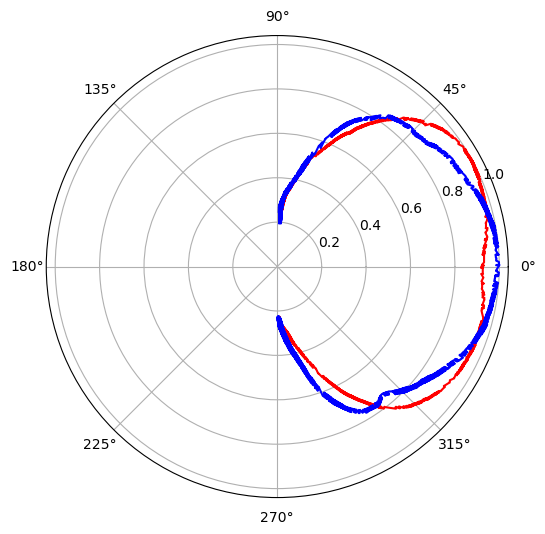

In [11]:
# Plot the data 
plt.figure(figsize=(10, 6))
plt.polar(np.radians(df_angular_x['Angle']), df_angular_x['Intensity'], label='X-Axis', c='red')
plt.polar(np.radians(df_angular_y['Angle']), df_angular_y['Intensity'], label='Y-Axis', c='blue')

### Obtain a fit for the angular response

C:\Users\nkottap\AppData\Local\Temp\ipykernel_26488\2540175151.py:12: RankWarning: Polyfit may be poorly conditioned
  coeffs_y = np.polyfit(df_angular_y['Angle'], df_angular_y['Intensity'], degree_y)


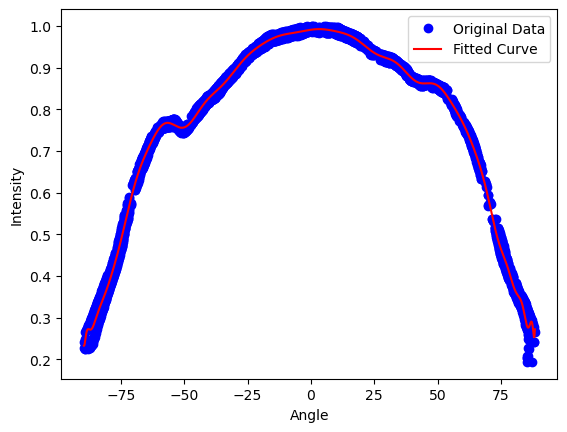

In [12]:
# Fit a polynomial to the data
degree_x = 20 # choose the degree of the polynomial
coeffs_x = np.polyfit(df_angular_x['Angle'], df_angular_x['Intensity'], degree_x)

# Generate x values for the fitted curve
x_fit_x = np.linspace(min(df_angular_x['Angle']), max(df_angular_x['Angle']), 1000)

# Evaluate the fitted curve at the x values
y_fit_x = np.polyval(coeffs_x, x_fit_x)

degree_y = 50 # choose the degree of the polynomial
coeffs_y = np.polyfit(df_angular_y['Angle'], df_angular_y['Intensity'], degree_y)

# Generate x values for the fitted curve
x_fit_y = np.linspace(min(df_angular_y['Angle']), max(df_angular_y['Angle']), 1000)

# Evaluate the fitted curve at the x values
y_fit_y = np.polyval(coeffs_y, x_fit_y)

# Plot the original data and the fitted curve
# plt.plot(df_angular_x['Angle'], df_angular_x['Intensity'], 'o', label='Original Data')
# plt.plot(x_fit_x, y_fit_x, label='Fitted Curve')
plt.plot(df_angular_y['Angle'], df_angular_y['Intensity'], 'o', label='Original Data', c='blue')
plt.plot(x_fit_y, y_fit_y, label='Fitted Curve', c='red')
plt.xlabel('Angle')
plt.ylabel('Intensity')
plt.legend()
plt.show()


In [13]:
# Creating a meshgrid of points
x_grid, y_grid = np.meshgrid(x_fit_x, x_fit_y)

# Calculating the intensity at each point
z_grid = np.zeros(x_grid.shape)
for i in range(len(x_grid)):
    for j in range(len(x_grid[0])):
        z_grid[i, j] = np.polyval(coeffs_x, x_grid[i, j]) * np.polyval(coeffs_y, y_grid[i, j])

# Normalizing z_grid
z_grid /= np.max(y_fit_y)

emission_fit = np.stack((x_grid, y_grid, z_grid), axis=-1)

# Displaying the data
plt.figure(figsize=(8, 8))
plt.pcolormesh(emission_fit[...,0], emission_fit[...,1], emission_fit[...,2])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig('data/Power Response/Checkpoint/VLMTG1400 Emission.tif')
plt.close()

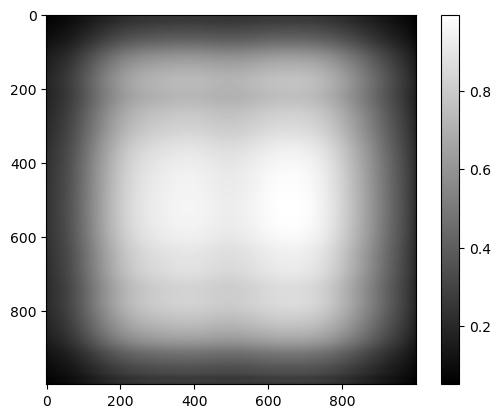

In [14]:
plt.imshow(emission_fit[...,2], cmap='gray')
plt.colorbar()

## Intermediate board power measurements

In [15]:
# Loading the intermediate file 
file_loc_inter = os.path.join(os.getcwd(), 'data', 'Power Response','Measurements', '2023-10-30 Intermediate Board Measuremetnts.csv')
df_inter = pd.read_csv(file_loc_inter, header=0)

# Converting to numpy array
inter_vals = np.zeros((len(df_inter), 4))
inter_vals[:,0] = df_inter['Source Board Voltage'].to_numpy()
inter_vals[:,1] = df_inter['Intermediate (+) Current'].to_numpy()
inter_vals[:,2] = df_inter['Intermediate (-) Current'].to_numpy()
inter_vals[:,3] = df_inter['Intermediate LED Current'].to_numpy()

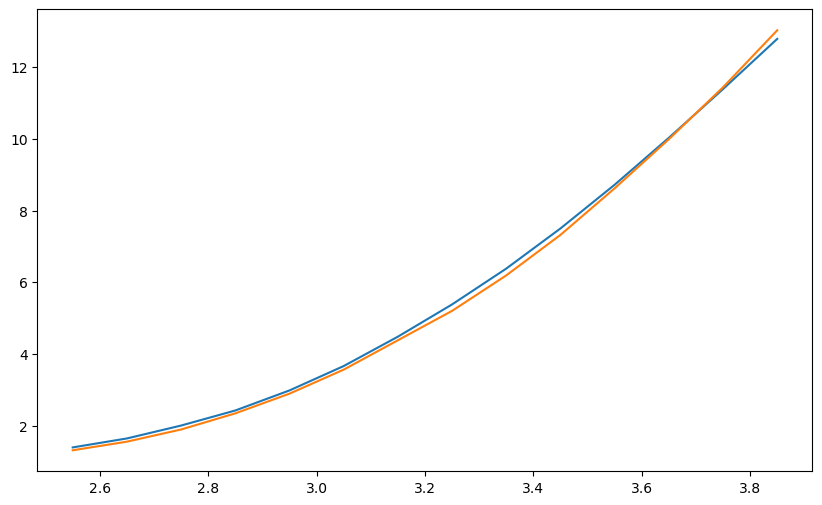

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(inter_vals[:,0], inter_vals[:,1], label='Intermediate (+) Current')
plt.plot(inter_vals[:,0], inter_vals[:,3], label='Intermediate LED Current')

In [17]:
# Calculate the power consumed
total_pow = inter_vals[:,0] * (inter_vals[:,1] + inter_vals[:,2])

# Check if the 'Total Power (mW)' column already exists
if 'Total Power (mW)' not in df_inter.columns:
    # Insert the 'Total Power (mW)' column into the dataframe
    df_inter.insert(5, 'Total Power (mW)', total_pow, True)

In [18]:
df_inter

,Source Board Voltage,Source Current,Intermediate (+) Current,Intermediate (-) Current,Intermediate LED Current,Total Power (mW)
0,2.55,0.96,1.39,0.95,1.31,5.9670
1,2.65,0.84,1.64,0.95,1.55,6.8635
2,2.75,0.92,2.00,0.95,1.89,8.1125
3,2.85,0.90,2.42,0.95,2.34,9.6045
4,2.95,1.04,2.98,0.95,2.89,11.5935
5,3.05,0.99,3.66,0.95,3.56,14.0605
6,3.15,1.18,4.48,0.95,4.38,17.1045
7,3.25,1.37,5.38,0.95,5.20,20.5725
8,3.35,1.46,6.38,0.95,6.19,24.5555
9,3.45,1.62,7.50,0.95,7.32,29.1525


## Photodiode Angular Data

### Loading the Fitted Data

In [19]:
file_loc_pd = 'out/Power/SFH2704 Directional Fit.csv'

# Reading the CSV file
df_pd = pd.read_csv(file_loc_pd, header=0)
pd_df_headers = df_pd.columns.values

### Fitting and plotting the data

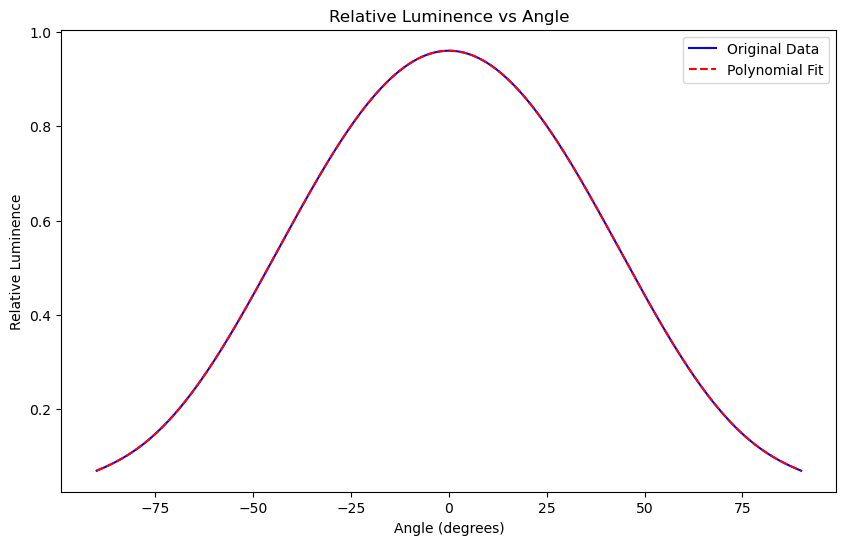

In [20]:
# Performing a polynomial fit
degree_pd = 7
pd_polyfit = fit_polynomial(df_pd[pd_df_headers[0]].to_numpy(), df_pd[pd_df_headers[1]].to_numpy(), degree_pd)

# Plot the fitted polynomial
plt.figure(figsize=(10, 6))
plt.plot(df_pd[pd_df_headers[0]].to_numpy(), df_pd[pd_df_headers[1]].to_numpy(), c='blue', label='Original Data')
plt.plot(df_pd[pd_df_headers[0]].to_numpy(), pd_polyfit(df_pd[pd_df_headers[0]].to_numpy()), c='red', linestyle='--', label='Polynomial Fit')
plt.xlabel('Angle (degrees)')
plt.ylabel('Relative Luminence')
plt.title('Relative Luminence vs Angle')
plt.legend()

# Estimating the Optical Transfer Function
The idea is to use the directionality of the instensity emitted from the LED VLMTG1400 and extimate how much total light might be incident on the LED. We can achieve this by calculating the magnification factor of the 

$$
\mathcal M = \frac{y_2}{y_1} = -\frac{z_2}{z_1}
$$

Which indicates that the size of the formed image is a magnified and inverted version of the detected image. I physically measure the image spot that is formed on the photodiode surface plane which I estimate to not change significantly for the distance between photodiode plane and detector plane. We further assume tha the photodiode is positioned at the center of the The total amount of light can be calculated from the light collected by the lens, imperfections in the lens and the amount of area in the image covered by the photodiode. As the distance between the lens ($d_1$) and the LED ($l_{LED}$) is much larger than the dimension of the emitter in the LED, i.e. $l_{LED} \gg d_1$, we can consider 
the LED to be a point source. So we can calculate the amount of light collected by the lens as follows

We follow these steps
1. **Calculate the aperture of the lens:** As the diameter of the lens is 25.4mm, that is also the aperture of the lens
 
2. **Calculate the solid angle:** The solid angle of the arc of light incident on the lens can be calculated using 
    $$ \Omega = 2 \pi (1 - \cos \theta)$$
    The $\cos \theta$ term needed to determine the solid angle can be calculated. For a lens place at the distance $z_1$ and radius of the lens $r_l$
            $$ \cos \theta = \frac{z_1}{\sqrt{z_1^2 + r^2}}$$

3. **Estimate the distribution of luminescence collected by the lens:** The total amount of light that is incident upon the photodiode depends on luminescence distribution. However, that depends on the solid angle that is the maximum covering the aperture of the lens. So we can cut off the sections that are outside the solid angle. This can be propagated to the image plane where the detector surface is

4. **Estimate the distribution of luminescence on the detector**: Based on what percentage of the detector surface covers the distribution of luminescence imaged from the lens, we can calculate the total luminescence incident on the surface of the lens

5. **Calculate the intensity on the photodiode**: As 1W = 683 lumens, we can calculate the intensity in $\frac{W}{cm^2}$

**Assumptions**
1. The LED, lens and the photodiode are centered with respect to each other.
2. The distance between the emitter and the lens is quite large compared to the emitter size

**Links**
1. [Edmund Optics](https://www.edmundoptics.com/knowledge-center/application-notes/optics/optics-application-examples/#:~:text=Solid%20angle%20is%20defined%20as,%CE%A9%20or%20%CE%A9'%2C%20respectively.)
2. [ChatGPT](https://chat.openai.com/share/d4a87d83-a697-47c8-98ad-9012b5469c3b)

## Calculating the angle subtended by the lens

In [21]:
em_lens_dist = 120 * mm
lens_det_dist = 100 * mm
lens_diameter = 25.4 * mm

# Caclculating the cosine theta term
cos_theta = em_lens_dist**2 / np.sqrt(em_lens_dist**2 + (lens_diameter / 2)**2)

# Calculating the solid angle
solid_angle = 2 * np.pi * (1 - cos_theta)
# solid_angle = np.rad2deg(np.pi * (lens_diameter / 2)**2 / lens_dist**2)

# Calculating throughput
refraction_index = 1.5
throughput = refraction_index**2 * solid_angle * np.pi * (lens_diameter / 2)**2 

# Finding the angle
angle = np.rad2deg(2 * np.arctan(lens_diameter / (2 * em_lens_dist)) )

In [54]:
# Cropping emission_fit to the angles accepted by the lens
mask_x = np.logical_and(x_grid >= -angle/2, x_grid <= angle/2)
mask_y = np.logical_and(y_grid >= -angle/2, y_grid <= angle/2)
mask = np.logical_and(mask_x, mask_y)

emission_fit_masked = emission_fit.copy()
emission_fit_masked[~mask] = 0

# Finding the ratio of emissions
emission_fit_ratio = np.sum(emission_fit_masked[:,:,2]) / np.sum(emission_fit[:,:,2])
 
em_fit_m = np.argwhere(emission_fit_masked[:,:,2])
x_min, y_min = em_fit_m.min(axis=0)
x_max, y_max = em_fit_m.max(axis=0)

emission_fit_cropped = emission_fit_masked[x_min:x_max, y_min:y_max, :]

In [81]:
emission_fit_ratio

0.007219644881297049

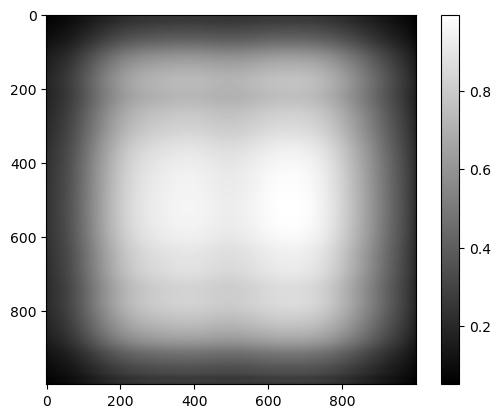

In [77]:
plt.imshow(emission_fit[...,2], cmap='gray')
plt.colorbar()

In [55]:
emission_fit_ratio

0.007219644881297049

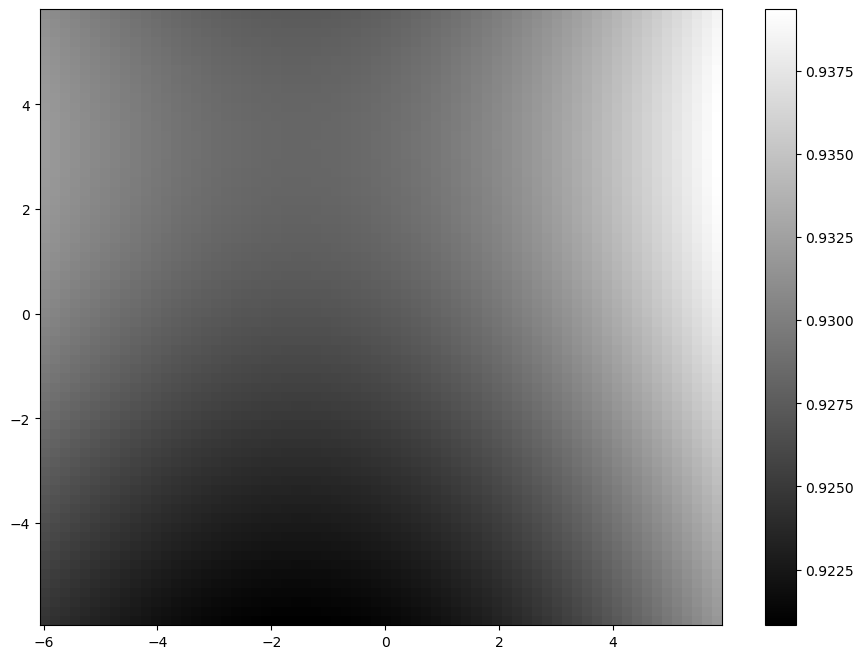

In [23]:
plt.figure(figsize=(11, 8))
plt.pcolormesh(emission_fit_cropped[...,0], emission_fit_cropped[...,1], emission_fit_cropped[...,2], cmap='gray')
plt.colorbar()

## Estimating the final intensity on the photodiode
### Modifying the image

In [24]:
# Defining Sizes
emitter_size = [500*um, 500*um]
detector_size = [1.4*mm, 1.4*mm]
spot_size = [3*mm, 3*mm]
magnification = [emitter_size[0]/detector_size[0], emitter_size[1]/detector_size[1]]

In [25]:
# Cropping and swapping the axes of the light collected by the LED and that is imaged onto the detector. This follows a thin lens approximation
# Creating the meshgrid of points
spot_x, spot_y = np.meshgrid(np.linspace(-spot_size[0]/2, spot_size[0]/2, emission_fit_cropped.shape[1]), np.linspace(-spot_size[1]/2, spot_size[1]/2, emission_fit_cropped.shape[0]))

# Creating a new array spot that holds the final information
spot = np.zeros((emission_fit_cropped.shape[0], emission_fit_cropped.shape[1], 3))
spot[...,0] = spot_x
spot[...,1] = spot_y

# Seleccting the relevant segments
inter_spot_00 = np.flip(emission_fit_cropped[0:emission_fit_cropped.shape[0]//2, 0:emission_fit_cropped.shape[1]//2,  2])
inter_spot_01 = np.flip(emission_fit_cropped[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], 0:emission_fit_cropped.shape[1]//2,  2])
inter_spot_10 = np.flip(emission_fit_cropped[0:emission_fit_cropped.shape[0]//2, emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2])
inter_spot_11 = np.flip(emission_fit_cropped[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2])

# Swappign the indices
spot[0:emission_fit_cropped.shape[0]//2, 0:emission_fit_cropped.shape[1]//2,  2] = inter_spot_11
spot[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], 0:emission_fit_cropped.shape[1]//2,  2] = inter_spot_10
spot[0:emission_fit_cropped.shape[0]//2, emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2] = inter_spot_01
spot[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2] = inter_spot_00

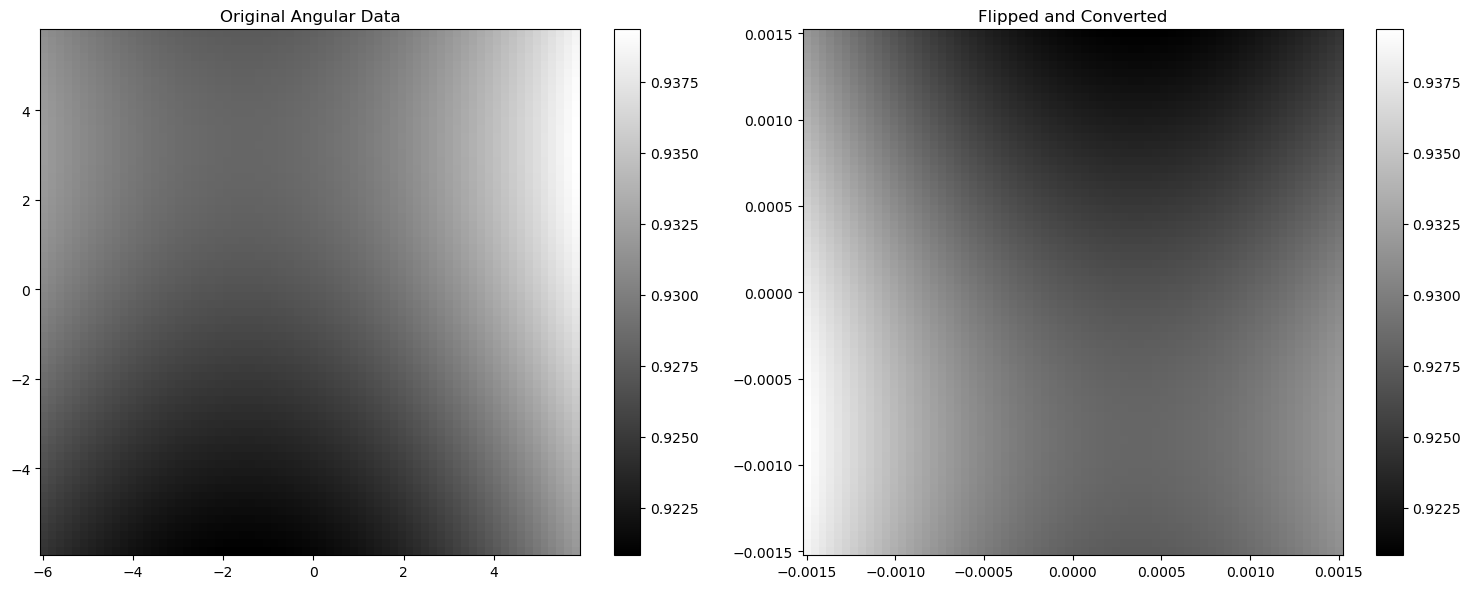

In [26]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(emission_fit_cropped[:,:,0], emission_fit_cropped[:,:,1], emission_fit_cropped[:,:,2], cmap='gray')
plt.title('Original Angular Data')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(spot[...,0], spot[...,1], spot[...,2], cmap='gray')
plt.title('Flipped and Converted')
plt.colorbar()

plt.tight_layout()
plt.show()


In [27]:
# Selecting the indices that satisfy the condition
detector_mask_x = np.logical_and(spot_x < detector_size[0]/2, spot_x > -detector_size[0]/2)
detector_mask_y = np.logical_and(spot_y < detector_size[1]/2, spot_y > -detector_size[1]/2)
detector_mask = np.logical_and(detector_mask_x, detector_mask_y)

# Creating the detector_light matrix
detector_light = np.zeros((spot_x.shape[0], spot_x.shape[1], 3))
detector_light[detector_mask] = spot[detector_mask]

# Cropping to size
detector_light_m = np.argwhere(detector_light[:,:,2])
x_min, y_min = detector_light_m.min(axis=0)
x_max, y_max = detector_light_m.max(axis=0)

detector_light_cropped = detector_light[x_min:x_max, y_min:y_max, :]


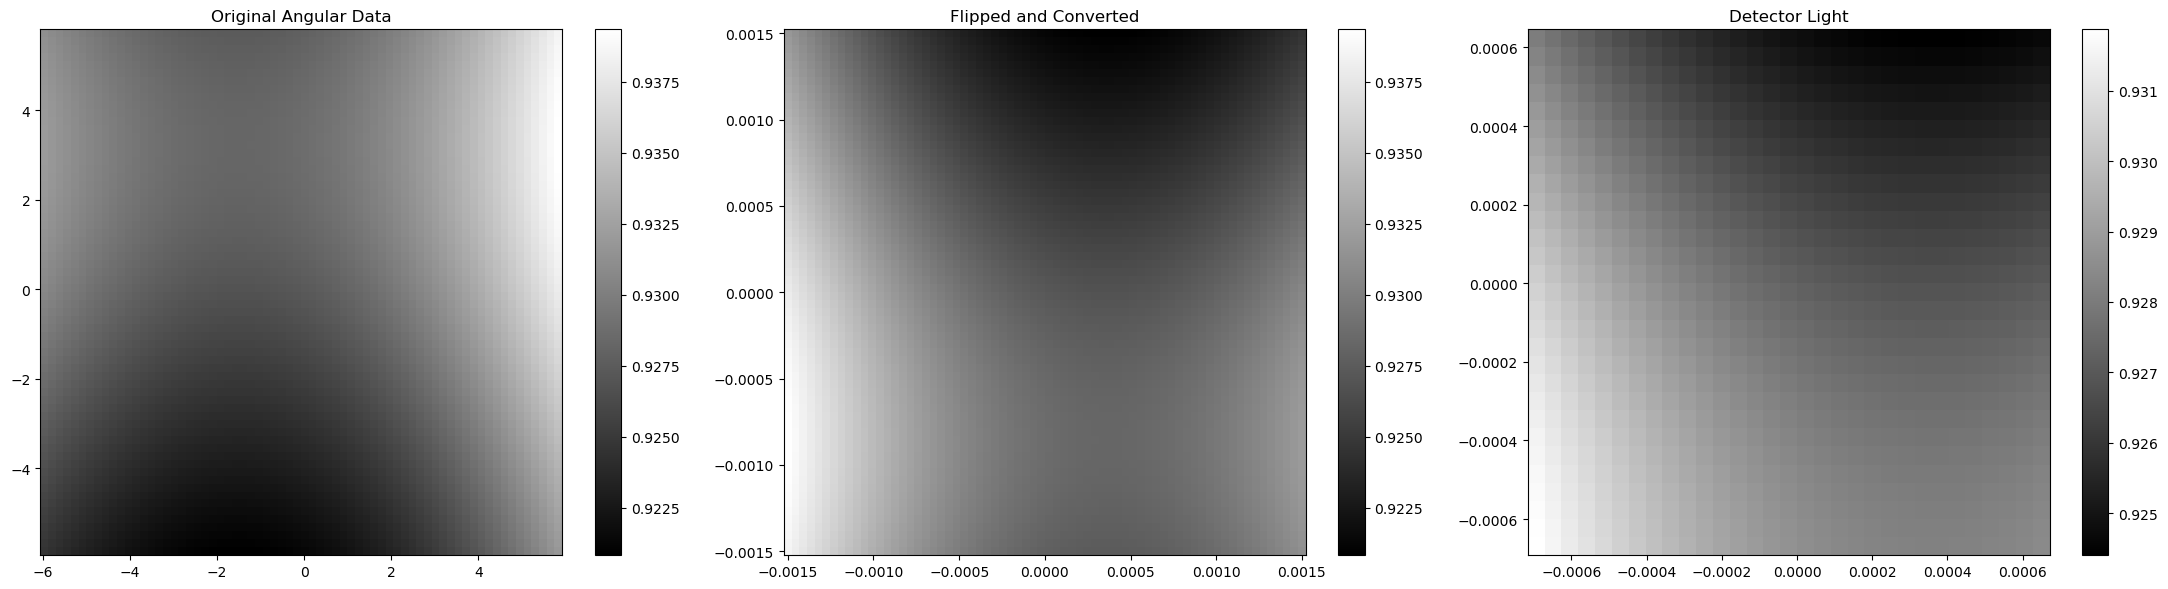

In [28]:
plt.figure(figsize=(22, 6))

plt.subplot(1, 3, 1)
plt.pcolormesh(emission_fit_cropped[:,:,0], emission_fit_cropped[:,:,1], emission_fit_cropped[:,:,2], cmap='gray')
plt.title('Original Angular Data')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.pcolormesh(spot[...,0], spot[...,1], spot[...,2], cmap='gray')
plt.title('Flipped and Converted')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.pcolormesh(detector_light_cropped[:,:,0], detector_light_cropped[:,:,1], detector_light_cropped[:,:,2], cmap='gray')
plt.title('Detector Light')
plt.colorbar()

plt.tight_layout()
plt.show()

## Applying the detector angular response on the detector image

Text(0.5, 1.0, 'Relative Luminence vs Angle')

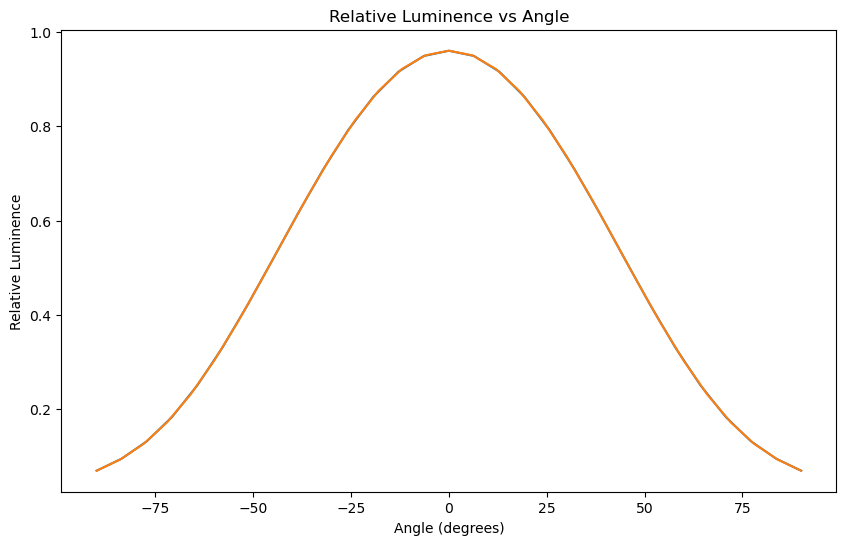

In [29]:
# Create a 1D array from pd_polynomial_fit
angles_pd_0 = np.linspace(-90, 90, detector_light_cropped.shape[0])
angles_pd_1 = np.linspace(-90, 90, detector_light_cropped.shape[1])

# Calculate from the fit
relative_luminescence_0 = pd_polyfit(angles_pd_0)
relative_luminescence_1 = pd_polyfit(angles_pd_1)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(angles_pd_0, relative_luminescence_0, label='Relative Luminence vs Angle')
plt.plot(angles_pd_1, relative_luminescence_1, label='Relative Luminence vs Angle')
plt.xlabel('Angle (degrees)')
plt.ylabel('Relative Luminence')
plt.title('Relative Luminence vs Angle')

Text(0.5, 1.0, 'Directionality of SFH 2704')

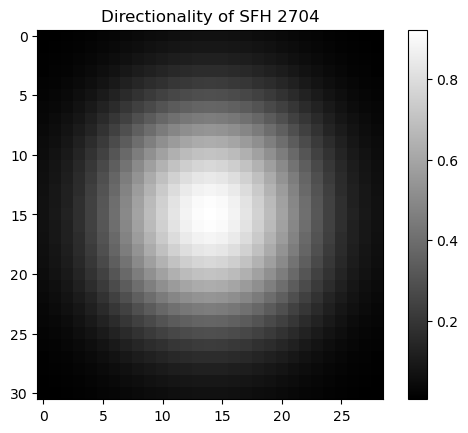

In [30]:
# Turn relative luminescence_fit_0 into a 2D array
relative_luminescence_0_2d = np.tile(relative_luminescence_0, (detector_light_cropped.shape[1], 1))

# Turn relative luminescence_fit_1 into a 2D array
relative_luminescence_1_2d = np.tile(relative_luminescence_1, (detector_light_cropped.shape[0], 1)).T

# Multiply the two arrays together
relative_luminescence_2d = relative_luminescence_0_2d * relative_luminescence_1_2d

# Plotting the directionality
plt.imshow(relative_luminescence_2d, cmap='gray')
plt.colorbar()
plt.title('Directionality of SFH 2704')

Text(0.5, 1.0, 'Signal measured because of directionality')

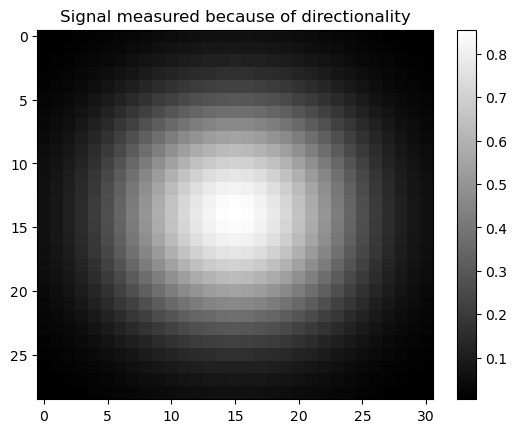

In [31]:
# Multiplying this directional characteristic with the detector light
detector_light_directional = detector_light_cropped.copy()
detector_light_directional[:,:,2] *= relative_luminescence_2d.T

# Plotting the directionality
plt.imshow(detector_light_directional[:,:,2], cmap='gray')
plt.colorbar()
plt.title('Signal measured because of directionality')

## Calculating the photocurrent generated from the photodiode

In [32]:
# Calculating the total luminescence on the detector area
total_luminescence = np.zeros(len(meas_vals[:,2]))

for i in range(len(meas_vals[:,2])):
    total_luminescence[i] = np.sum(detector_light_directional[:,:,2] * meas_vals[i,2])

# Converting to Watt
total_power = total_luminescence/683

# Converting to Intensity (power in mW from above and dividing by area of the photodiode detector (in cm^2) to get the final intensity in mW/cm^2)
final_intensity = total_power / 151

# Amount of photocurrent generated by the photodiode (in microAmps)
photocurrent = final_intensity * 0.51

Text(0.5, 1.0, 'Photocurrent vs Voltage to Source Board')

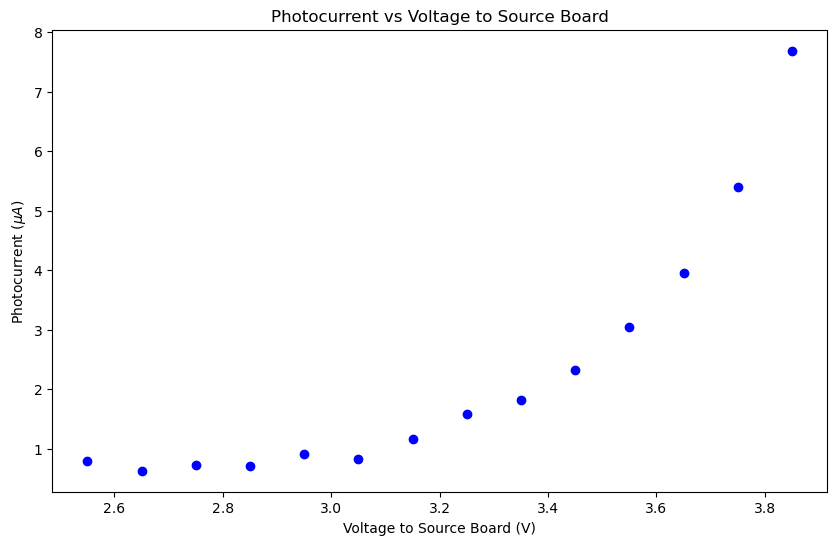

In [33]:
# Plotting Voltage vs Photocurrent
plt.figure(figsize=(10, 6))
plt.scatter(meas_vals[:, 0], photocurrent, c='blue')
plt.xlabel('Voltage to Source Board (V)')
plt.ylabel(r'Photocurrent ($\mu A$)')
plt.title('Photocurrent vs Voltage to Source Board')

In [34]:
# Calculating the power consumed with intensity

# Create a new dataframe df_power
df_power = pd.DataFrame({'Source Voltage': meas_vals[:, 0], 'Intensity': final_intensity, 'Photocurrent': photocurrent})

# Find the corresponding values from df_inter
df_power['Total Power'] = df_power['Source Voltage'].apply(lambda x: df_inter[df_inter['Source Board Voltage'] == x]['Total Power (mW)'].values[0])


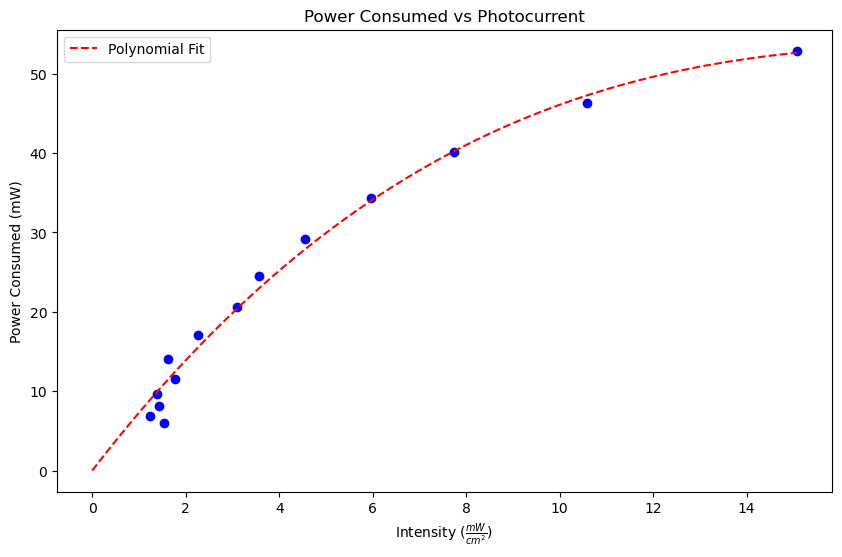

In [148]:
def fit_func_int_pow(x, p1, p2, p3):
    return p1 * x**3 + p2 * x**2 + p3 * x 

# Fit this plot with a polynomial
int_pow_params, _ = curve_fit(fit_func_int_pow, df_power['Intensity'], df_power['Total Power'])
x_inter_int_pow_fit = np.linspace(0, max(df_power['Intensity']), 1000)
inter_int_pow_fit = fit_func_int_pow(x_inter_int_pow_fit, *int_pow_params)

# Plot of power consumed vs incident intensity
plt.figure(figsize=(10, 6))
plt.scatter(df_power['Intensity'], df_power['Total Power'], c='blue')
plt.plot(x_inter_int_pow_fit, inter_int_pow_fit, c='red', linestyle='--', label='Polynomial Fit')
plt.xlabel(r'Intensity $(\frac{mW}{cm^2})$')
plt.ylabel('Power Consumed (mW)')
plt.title('Power Consumed vs Photocurrent')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Power Consumed vs Photocurrent')

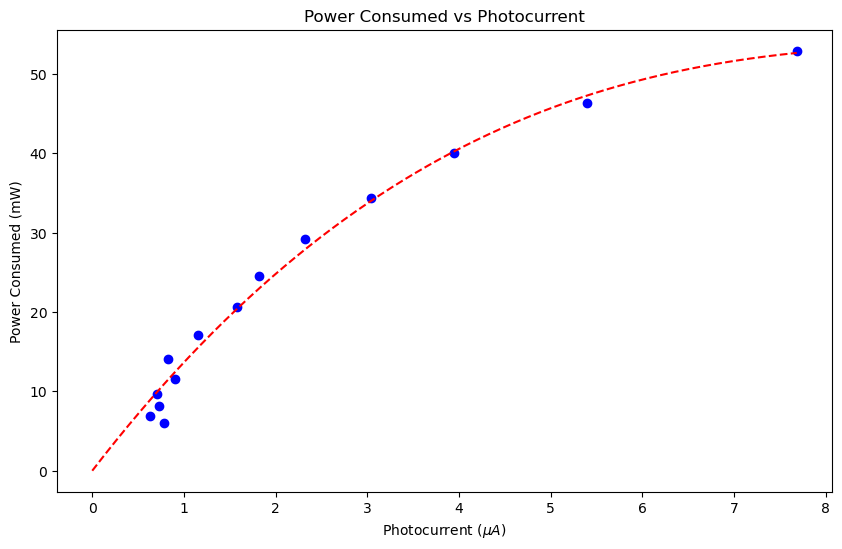

In [151]:
def fit_func_pc_pow(x, p1, p2, p3):
    return p1 * x**3 + p2 * x**2 + p3 * x

# Fit this plot with a polynomial
pc_pow_params, _ = curve_fit(fit_func_pc_pow, df_power['Photocurrent'], df_power['Total Power'])
x_inter_pc_pow_fit = np.linspace(0, max(df_power['Photocurrent']), 1000)
inter_pc_pow_fit = fit_func_pc_pow(x_inter_pc_pow_fit, *pc_pow_params)

# Plot of power consumed vs photocurrent
plt.figure(figsize=(10, 6))
plt.scatter(df_power['Photocurrent'], df_power['Total Power'], c='blue')
plt.plot(x_inter_pc_pow_fit, inter_pc_pow_fit, c='red', linestyle='--', label='Polynomial Fit')
plt.xlabel(r'Photocurrent $(\mu A)$')
plt.ylabel('Power Consumed (mW)')
plt.title('Power Consumed vs Photocurrent')

In [154]:
# Selecting the photocurrent value under consideration to be 0.8 microAmps
# This number is just an educated guess based on the amplification and matching the detected light leqvel so that light decay through the system is non-existent
# Might be suspect as with the amplification and the desired photocurrent, we get 2nA. Setting this value instead of 0.8 uA
# pc_val = 0.8
pc_val = 0.002

# Number of channels on the board
num_channels = 32

# Find the power consumed at this value
power_consumed = fit_func_pc_pow(pc_val, *pc_pow_params) * 10**-3
power_consumed

2.9957889706927833e-05

In [155]:
power_consumed * num_channels

0.0009586524706216906

# Calculating the number of operations performed by the board
An operation in this instance can be defined a multiplicative operation perfromed by the scheme. The modulation of light emitted from a single LED modulated by a single mini-block can be treated as a product. For an emitter board the size of $m_e \times n_e$ and the detector board of size $m_d \times n_d$, for a single element on the emitter board, the total number of operations that happen are $m_d \times m_e \times n_d \times n_e$. 

For the boards used for this calculation, the following parameters are used
1. $m_d = 4$
2. $n_d = 8$
3. $m_e = 8$
4. $n_e = 8$ 

So for a single layer at a single time step, this gives us the multiplicative operations to be 2048. In addition, we also have 32 subtraction operations. So, the total number of operations at a single time step becomes 2080. However the system has been tested to operate at 500 kHz. This means that there are 500 kHz operations that are occuring in a second. So the total number of operations a second is $5 \cdot 10^8 \times 2080 = 1.04 \;\text{TOPS}$

The system in total consumes $327.33 \; \text{mW}$ for the amount of light that is in the system. This gives us a final value of $3.18 \;\text{TOPS/W}$. This is in contrast to the value for the top of the line GPU for AI, that is Nvidia H100 which is $0.59 \; \text{TOPS/W}$. However H100s performance might be better if we consider it's FP8 performance which gives $8.8\; \text{TOPS/W}$. However, use of FP8 for neural networks is currently being examined and is not in use for applications at the moment.  In the world of ASICs, Google TPU v4, the leading machine learning ASIC in its latest iteration has $1.6 \;\text{TOPS/W}$.

To conclude, the system is quite competitive when compared to existing systems


**Links**
1. [NVIDIA RTX 4090](https://www.techpowerup.com/gpu-specs/geforce-rtx-4090.c3889)
2. [NVIDIA H100](https://www.techpowerup.com/gpu-specs/h100-pcie-80-gb.c3899)
3. [Google TPU v4](https://en.wikipedia.org/wiki/Tensor_Processing_Unit)

## Individual case
### Experimental Condition

In [156]:
## Testing for the experimental conditions
# Setting the number of TOPS/W for our system
dim_exp = [8,8]
freq_exp = 5 * 10**5
num_op_exp = (dim_exp[0]**2 * dim_exp[1]**2 * 0.5)+(dim_exp[0]/2 * dim_exp[1])
num_ops_exp = num_op_exp * (freq_exp)
tops_w = num_ops_exp/(power_consumed * num_channels * 10**12)

In [185]:
num_channels

32

### Maximum under diffraction limit

In [158]:
# Theoretical diffraction limit on size scaling of the system
max_arr_size = [32, 32]

# Maximum Permissible under scaling laws
# Number of ops for the max array size
op_max = (max_arr_size[0] * max_arr_size[1] * max_arr_size[0]/2 * max_arr_size[1])+(max_arr_size[0]/2 * max_arr_size[1])
ops_max = op_max * (500 * 10**6)

# Assuming that the power consumption stays the same as the light level in the system stays the same and we can indefinitely scale it down to less than 1 photon/operation (cite McMahon paper). This holds true as from the power measurements for a single channel, it is clear that the majority of the power is consumed by the LED. The power consumed by the rest of the system is negligible in comparison.
# Calculate the power consumed per operation for the case of maximum operations
tops_w_max = ops_max/(power_consumed * num_channels)/10**9

## Plotting the scaling
### Scaling with size

In [159]:
# Creating an arry of detector_size
dim_arr = np.zeros((13, 2))
dim_arr[:, 0] = np.arange(8, 34, 2)
dim_arr[:, 1] = np.arange(8, 34, 2)

# Calculating the number of operations at a time step
op_arr = (dim_arr[:, 0]**2 * 0.5 * dim_arr[:, 1]**2) + (dim_arr[:, 0] * 0.5 * dim_arr[:, 1])

# Calculating the number of operations per second
ops_arr = op_arr * (5 * 10**5)

# Calculating the power consumed per operation
tops_w_arr = ops_arr/(power_consumed * num_channels * 10**12)

In [184]:
num_channels

32

In [183]:
power_consumed * num_channels

0.0009586524706216906

Text(0.5, 1.0, 'Scaling with increasing size of array')

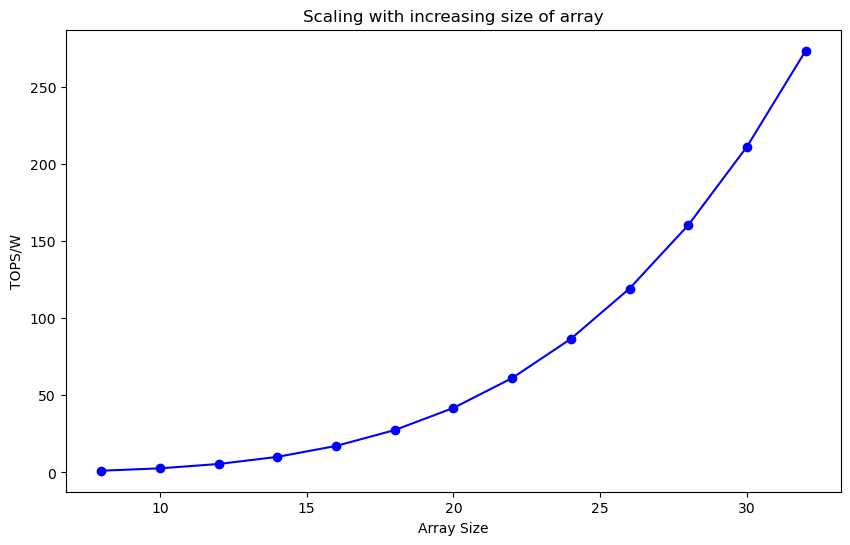

In [160]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(dim_arr[:,0], tops_w_arr, 'o-', c='blue')
plt.xlabel('Array Size')
plt.ylabel('TOPS/W')
plt.title('Scaling with increasing size of array')



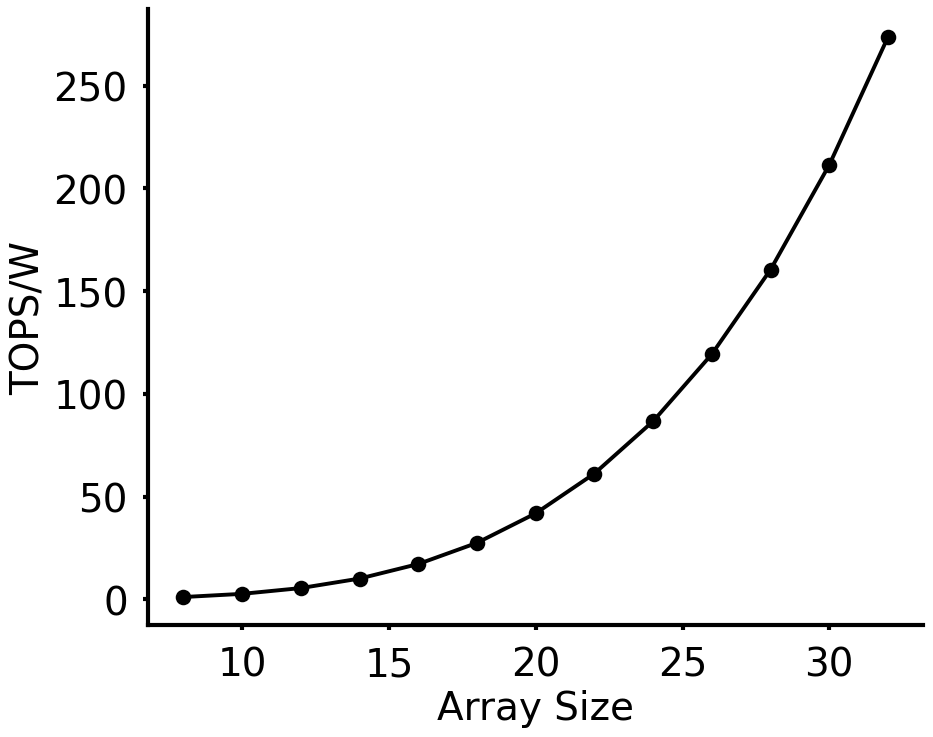

In [180]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(dim_arr[:,0], tops_w_arr, 'o-', c='k')
# plt.title('Scaling with increasing size of array')
# ax.legend(fontsize=28)

ax.set_ylabel('TOPS/W', fontsize=28)
ax.set_xlabel('Array Size', fontsize=28)

ax.tick_params(axis='both', labelsize=28, width=3)

# Increase the line thickness of the bounding box
for spine in ax.spines.values():
    spine.set_linewidth(3)

# Remove splines on top and right sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
# Add splines on left and bottom sides
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('out/Power/power-size-scaling.pdf', bbox_inches='tight')
plt.show()


### Scaling with frequency
There are commercially available 1GSPS ADC chip such as [ADC08D1000](https://www.ti.com/lit/ds/symlink/adc08d1000.pdf?ts=1701709167422&ref_url=https%253A%252F%252Fwww.google.com%252F) from Texas instruments. However the limitation in that is power consumption and complexity of supporting electronics. Additionally the limitation with data-transfer rates gets into play here. The data-rate required to process  single channel at 1GSPS is 8Gbps. When we scale this out to array sizes such as $32 \times 32$, we get to a data-rate of  8.192 Tbps and the cards with fastest transfer rates is 512 Gbps with PCI Express v5 x16 ([source](https://www.electronicshub.org/how-many-pcie-lanes-do-i-have/)). So we need 16 PCI Express v5 ×16 lanes to process this amount of data which leads to the main bottleneck. For demonstration, we consider datarates that are feasible with a single PCIe v5 ×16 connector which would be 62.5MSPS

In [161]:
# Creating an array of frequencies
freq_arr = np.arange(0.5, 63, 1) * 10**6

# Setting other parameters
dim_freq_arr_1 = [32, 32]
dim_freq_arr_2 = [16, 16]
dim_freq_arr_3 = [8, 8]

# Calculating
# Calculating the number of operations at a time step
op_arr_1 = (dim_freq_arr_1[0]**2 * 0.5 * dim_freq_arr_1[1]**2) + (dim_freq_arr_1[0] * 0.5 * dim_freq_arr_1[1])
op_arr_2 = (dim_freq_arr_2[0]**2 * 0.5 * dim_freq_arr_2[1]**2) + (dim_freq_arr_2[0] * 0.5 * dim_freq_arr_2[1])
op_arr_3 = (dim_freq_arr_3[0]**2 * 0.5 * dim_freq_arr_3[1]**2) + (dim_freq_arr_3[0] * 0.5 * dim_freq_arr_3[1])

# Calculating the number of operations per second
ops_arr_1 = op_arr_1 * freq_arr
ops_arr_2 = op_arr_2 * freq_arr
ops_arr_3 = op_arr_3 * freq_arr

# Calculating the power consumed per operation
tops_w_arr_1 = ops_arr_1/(power_consumed * num_channels * 10**12)
tops_w_arr_2 = ops_arr_2/(power_consumed * num_channels * 10**12)
tops_w_arr_3 = ops_arr_3/(power_consumed * num_channels * 10**12)

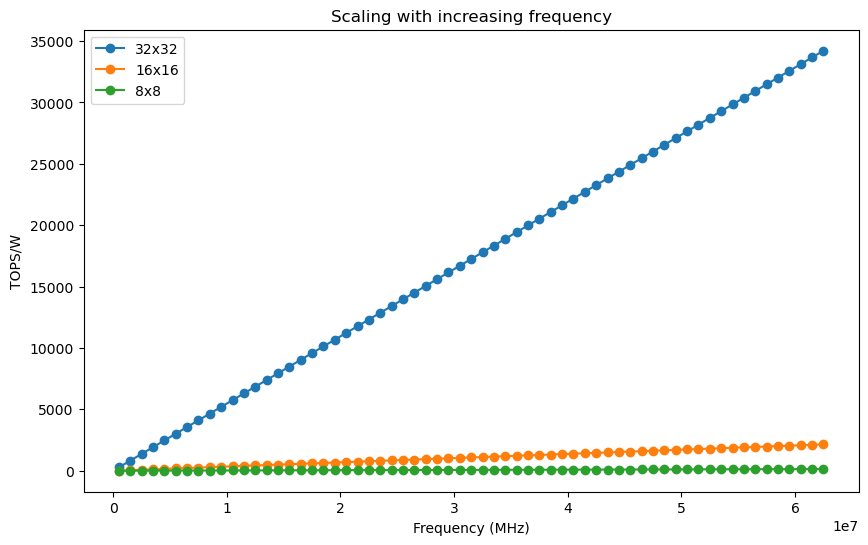

In [162]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(freq_arr, tops_w_arr_1, 'o-', label='32x32')
plt.plot(freq_arr, tops_w_arr_2, 'o-', label='16x16')
plt.plot(freq_arr, tops_w_arr_3, 'o-', label='8x8')
plt.xlabel('Frequency (MHz)')
plt.ylabel('TOPS/W')
plt.title('Scaling with increasing frequency')
plt.legend()


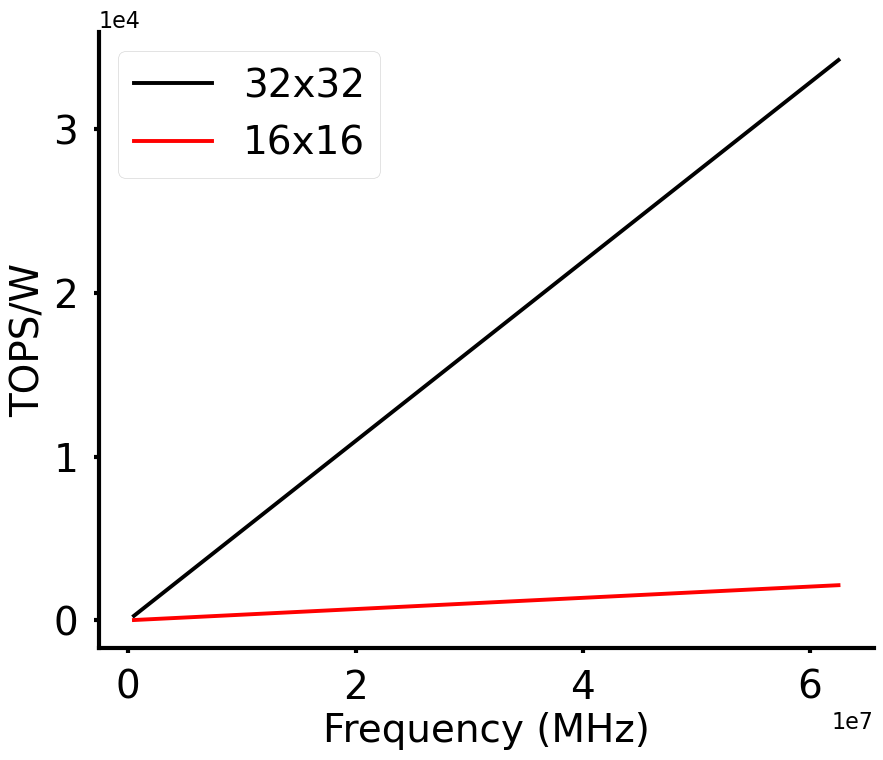

In [176]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(freq_arr, tops_w_arr_1, '-', c='k', label='32x32')
plt.plot(freq_arr, tops_w_arr_2, '-', c='r', label='16x16')
# plt.title('Scaling with increasing size of array')
ax.legend(fontsize=28)

ax.set_ylabel('TOPS/W', fontsize=28)
ax.set_xlabel('Frequency (MHz)', fontsize=28)

ax.tick_params(axis='both', labelsize=28, width=3)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Increase the line thickness of the bounding box
for spine in ax.spines.values():
    spine.set_linewidth(3)

# Remove splines on top and right sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
# Add splines on left and bottom sides
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('out/Power/power-speed-scaling.pdf', bbox_inches='tight')
plt.show()


# Caculating for a 2nA photocurrent through the photodiodes

In [163]:
# Calculating the amount of voltage that would have been necessary at the source board to get the desired photocurrent
power = (intensity * 151)
luminescence = power * 683
light_from_source = luminescence / np.sum(detector_light_directional[...,2])

# Converting to the light-field pre-photodiode
inverse_light_pd = spot.copy()
inverse_light_pd[...,2] = spot[...,2] * (light_from_source / np.sum(detector_light_cropped[...,2]))

# Skipping all the intermediate steps as we ar eonly interested in the sum at this stage and not in the exact shape of the beam

# Applying the lens factor
inverse_light_led = emission_fit.copy()
inverse_light_led[...,2] = emission_fit[...,2] * (np.sum(inverse_light_pd[...,2])/np.sum(emission_fit_cropped)) * (1/emission_fit_ratio)

# Calculaing the value of light from LED
inverse_led_light = np.unique(np.round(inverse_light_led[...,2] / emission_fit[...,2], 9))[0] * 10**3 # mCd

# Calculating the current through the LED


It is not possible to generate such little light from the LED with the current setup for characterizing. So trying out an alternate whereby I force the fits to go through (0,0) to get a better estimate of the problem